In [2]:
# NEED TO USE predictors_simple kernel to be able to load the modles
import numpy as np
import pandas as pd
import tensorflow as tf # tested on version 2.2.0
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.sans-serif'] = 'Arial'
from matplotlib import pyplot as plt
from joblib import load
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import auc
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import seaborn as sns


import os

os.chdir("/Users/claireleblanc/Documents/grad_school/staller_lab/NN_interpretability_for_AD_prediction/scripts")
from Model import ADModel_act, ADModel_abund, ADModel_three_state_abund, ADModel_two_state_abund
from Data import DataReader, SplitData, FastTensorDataLoader, one_hot_encode

os.chdir("/Users/claireleblanc/Documents/tools_software/PADDLE")

import paddle
import os

os.chdir("/Users/claireleblanc/Documents/tools_software/adhunter")
from actpred.models import ActCNNSystem

# Set Numpy to display floats with 3 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

os.chdir("/Users/claireleblanc/Documents/grad_school/staller_lab/NN_interpretability_for_AD_prediction")

In [2]:
import matplotlib 
# For higher resoltion figures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica" #somethings this one doesnt work
plt.rcParams['pdf.fonttype'] = 42

In [17]:
# BIOPHYSICAL MODEL STUFF
import torch

size = (1,40,20)
positive = False
activity_fun = "Hill"
hill_value = 1
relu = False
kernel_size = 10
outchannel = 1
model = "model_data/simple_actmodel_b10_e200_L0.0001_sMinMax_c1_k10_wp0.1_ParaReLU_hSplit_seed1792777_weightInit"
simple_model = ADModel_act(size,kernel_size)
simple_model.load_state_dict(torch.load(f"{model}.pth"))
simple_model.eval()

size = (1,40,20)
positive = False
activity_fun = "Hill"
hill_value = 1
relu = False
kernel_size = 40
outchannel = 1
model = "model_data/two_state_abundmodel_b10_e200_L0.0001_sMinMax_aHill_c1_k40_ak20_ParaReLU_0.1PosKLoss_0.1PosWeightLoss_1actLoss_hSplit_hv1_seed5273682_weightInit"
two_state_biophysical_model = ADModel_two_state_abund(size,activity_fun, kernel_size, relu=False, abund_k=20)
two_state_biophysical_model.load_state_dict(torch.load(f"{model}.pth"))
two_state_biophysical_model.eval()

size = (1,40,20)
positive = False
activity_fun = "Hill"
hill_value = 1
relu = False
kernel_size = 20
outchannel = 1
model = "model_data/three_state_abundmodel_b10_e200_L0.0001_sMinMax_aHill_c1_k20_ak20_ParaReLU_0.1PosKLoss_0.5PosWeightLoss_1actLoss_hSplit_hv1_seed830655019_weightInit"
three_state_biophysical_model = ADModel_three_state_abund(size,activity_fun, kernel_size, relu=False, abund_k=20)
three_state_biophysical_model.load_state_dict(torch.load(f"{model}.pth"))
three_state_biophysical_model.eval()

sc_act = load("scripts/scaler_activity.bin")

def run_biophysical_model(loaded_model,sequence):
    encoded_seq = one_hot_encode(sequence).reshape(1,1,40,20)
    seq_tensor = torch.from_numpy(encoded_seq).type(torch.FloatTensor)
    predictions = loaded_model(seq_tensor)
    predictions = predictions.detach().numpy().reshape(1, -1)
    return sc_act.inverse_transform(predictions)

/Users/claireleblanc/miniconda3/envs/predictors_simple/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [18]:
# ADHUNTER STUFF
kernel_size = 5
dilation = 3 
hidden = 64

gfp_model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
gfp_model.load_state_dict(torch.load("../../../tools_software/adhunter/adhunter_gfp.pt"))
gfp_model.eval()

mcherry_model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
mcherry_model.load_state_dict(torch.load("../../../tools_software/adhunter/adhunter_cherry.pt"))
mcherry_model.eval()

ratio_model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)

sc_gfp=load('../../../tools_software/adhunter/scaler_gfp.pkl')
sc_mcherry=load('../../../tools_software/adhunter/scaler_cherry.pkl')

alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}

def run_adhunter(model, sequence, sc):
    X = np.asarray([[aa_to_i[aa] for aa in sequence]])
    X = torch.tensor(X)
    result = model(X)
    result = sc.inverse_transform(result.detach().numpy().reshape(-1, 1))
    return result[0,0]


/Users/claireleblanc/miniconda3/envs/predictors_simple/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [24]:
hummel_data.loc[0,"53_tiles"]

['LADTKDVVPVDLVDFDHLITKDRLEEDESFEDFLTPQTEFHTDAIADLNVKDM',
 'LADTKDVVPVDLVDFDHLITKDRLEEDESFEDFLTPQTEFHTDAIADLNVKDM']

In [21]:
hummel_data =  pd.read_excel("/Users/claireleblanc/Downloads/mmc5.xlsx", skiprows=2)
hummel_data["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in hummel_data["protein"]]


hummel_data["simple_gfp_pred"] = [[run_biophysical_model(simple_model, tile)[0][0] for tile in tiles] for tiles in hummel_data["40_tiles"]]
hummel_data["two_state_gfp_pred"] = [[run_biophysical_model(two_state_biophysical_model, tile)[0][1] for tile in tiles] for tiles in hummel_data["40_tiles"]]
hummel_data["three_state_gfp_pred"] = [[run_biophysical_model(three_state_biophysical_model, tile)[0][1] for tile in tiles] for tiles in hummel_data["40_tiles"]]


hummel_data["adhunter_gfp_pred"] = [[run_adhunter(gfp_model, tile, sc_gfp) for tile in tiles] for tiles in hummel_data["40_tiles"]]


In [23]:
hummel_data["mean_simple_pred"] = [np.mean(ls) for ls in hummel_data["simple_gfp_pred"]]
hummel_data["mean_two_state_pred"] = [np.mean(ls) for ls in hummel_data["two_state_gfp_pred"]]
hummel_data["mean_three_state_pred"] = [np.mean(ls) for ls in hummel_data["three_state_gfp_pred"]]
hummel_data["mean_adhunter_pred"] = [np.mean(ls) for ls in hummel_data["adhunter_gfp_pred"]]

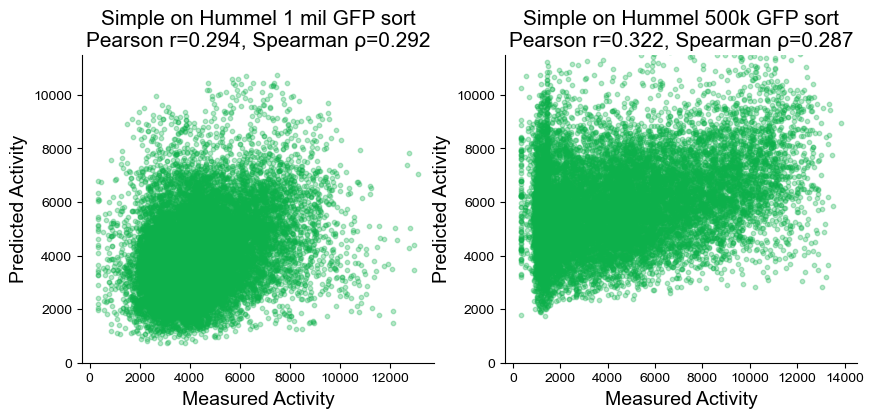

In [25]:
# Very similar to PADDLE --> 0.28 and 0.34 spearman

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].scatter(hummel_data["Activity_1mil_GFP_sort"], hummel_data["mean_simple_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(hummel_data["Activity_1mil_GFP_sort"], hummel_data["mean_simple_pred"]).correlation
pearson = pearsonr(hummel_data["Activity_1mil_GFP_sort"], hummel_data["mean_simple_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[0].set_xlabel('Measured Activity', fontsize=14)
axs[0].set_ylabel('Predicted Activity', fontsize=14)
axs[0].set_ylim(0, 11500)
axs[0].set_title(f'Simple on Hummel 1 mil GFP sort\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)

axs[1].scatter(hummel_data["Activity_500k_GFP_sort"], hummel_data["mean_adhunter_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(hummel_data.dropna()["Activity_500k_GFP_sort"], hummel_data.dropna()["mean_simple_pred"]).correlation
pearson = pearsonr(hummel_data.dropna()["Activity_500k_GFP_sort"], hummel_data.dropna()["mean_simple_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[1].set_xlabel('Measured Activity', fontsize=14)
axs[1].set_ylabel('Predicted Activity', fontsize=14)
axs[1].set_ylim(0, 11500)
axs[1].set_title(f'Simple on Hummel 500k GFP sort\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)

sns.despine()

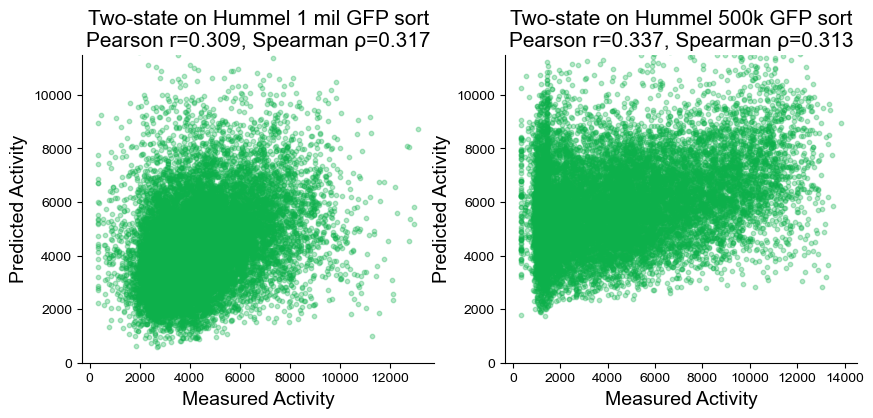

In [28]:
# Very similar to PADDLE --> 0.28 and 0.34 spearman

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].scatter(hummel_data["Activity_1mil_GFP_sort"], hummel_data["mean_two_state_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(hummel_data["Activity_1mil_GFP_sort"], hummel_data["mean_two_state_pred"]).correlation
pearson = pearsonr(hummel_data["Activity_1mil_GFP_sort"], hummel_data["mean_two_state_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[0].set_xlabel('Measured Activity', fontsize=14)
axs[0].set_ylabel('Predicted Activity', fontsize=14)
axs[0].set_ylim(0, 11500)
axs[0].set_title(f'Two-state on Hummel 1 mil GFP sort\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)

axs[1].scatter(hummel_data["Activity_500k_GFP_sort"], hummel_data["mean_adhunter_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(hummel_data.dropna()["Activity_500k_GFP_sort"], hummel_data.dropna()["mean_two_state_pred"]).correlation
pearson = pearsonr(hummel_data.dropna()["Activity_500k_GFP_sort"], hummel_data.dropna()["mean_two_state_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[1].set_xlabel('Measured Activity', fontsize=14)
axs[1].set_ylabel('Predicted Activity', fontsize=14)
axs[1].set_ylim(0, 11500)
axs[1].set_title(f'Two-state on Hummel 500k GFP sort\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)

sns.despine()

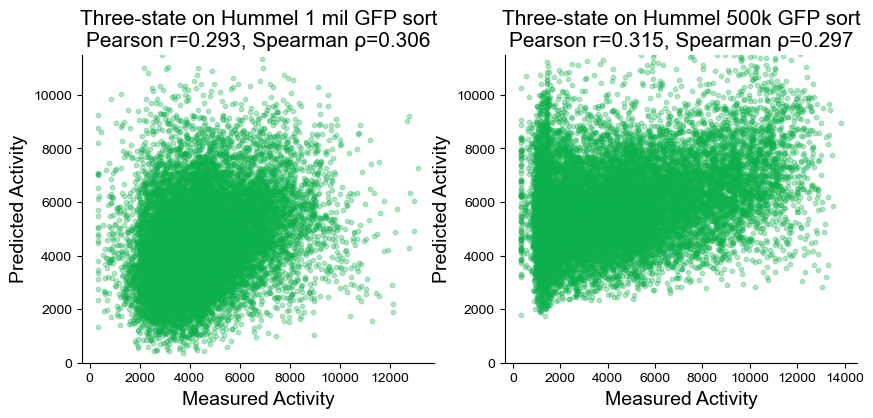

In [29]:
# Very similar to PADDLE --> 0.28 and 0.34 spearman

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].scatter(hummel_data["Activity_1mil_GFP_sort"], hummel_data["mean_three_state_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(hummel_data["Activity_1mil_GFP_sort"], hummel_data["mean_three_state_pred"]).correlation
pearson = pearsonr(hummel_data["Activity_1mil_GFP_sort"], hummel_data["mean_three_state_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[0].set_xlabel('Measured Activity', fontsize=14)
axs[0].set_ylabel('Predicted Activity', fontsize=14)
axs[0].set_ylim(0, 11500)
axs[0].set_title(f'Three-state on Hummel 1 mil GFP sort\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)

axs[1].scatter(hummel_data["Activity_500k_GFP_sort"], hummel_data["mean_adhunter_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(hummel_data.dropna()["Activity_500k_GFP_sort"], hummel_data.dropna()["mean_three_state_pred"]).correlation
pearson = pearsonr(hummel_data.dropna()["Activity_500k_GFP_sort"], hummel_data.dropna()["mean_three_state_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[1].set_xlabel('Measured Activity', fontsize=14)
axs[1].set_ylabel('Predicted Activity', fontsize=14)
axs[1].set_ylim(0, 11500)
axs[1].set_title(f'Three-state on Hummel 500k GFP sort\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)

sns.despine()

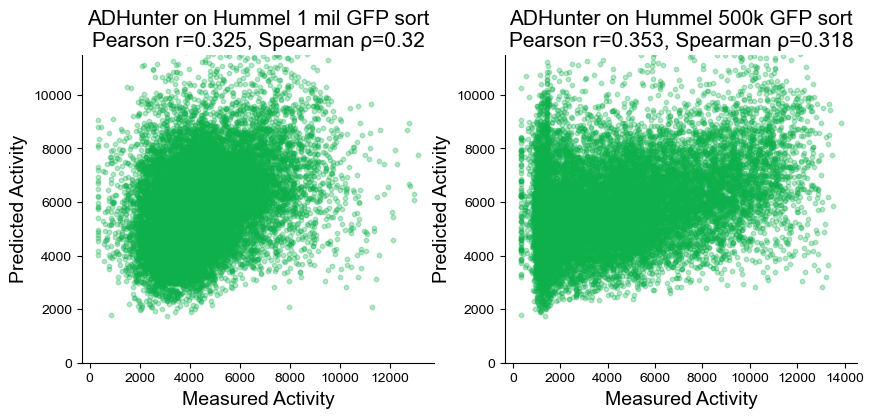

In [30]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].scatter(hummel_data["Activity_1mil_GFP_sort"], hummel_data["mean_adhunter_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(hummel_data["Activity_1mil_GFP_sort"], hummel_data["mean_adhunter_pred"]).correlation
pearson = pearsonr(hummel_data["Activity_1mil_GFP_sort"], hummel_data["mean_adhunter_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[0].set_xlabel('Measured Activity', fontsize=14)
axs[0].set_ylabel('Predicted Activity', fontsize=14)
axs[0].set_ylim(0, 11500)
axs[0].set_title(f'ADHunter on Hummel 1 mil GFP sort\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)

axs[1].scatter(hummel_data["Activity_500k_GFP_sort"], hummel_data["mean_adhunter_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(hummel_data.dropna()["Activity_500k_GFP_sort"], hummel_data.dropna()["mean_adhunter_pred"]).correlation
pearson = pearsonr(hummel_data.dropna()["Activity_500k_GFP_sort"], hummel_data.dropna()["mean_adhunter_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[1].set_xlabel('Measured Activity', fontsize=14)
axs[1].set_ylabel('Predicted Activity', fontsize=14)
axs[1].set_ylim(0, 11500)
axs[1].set_title(f'ADHunter on Hummel 500k GFP sort\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)

sns.despine()

# Marissa data

In [10]:
marissa_data = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Evolution_stuff/gcn4_paper_stuff/activity_heatmaps/marissa_data_wrangled.csv")

In [74]:
marissa_data = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/Synthetics_GFP.csv", index_col=0)
marissa_data = marissa_data.reset_index().rename({'AAseq' : 'aa_seq'}, axis=1)
marissa_data

,aa_seq,GFP_Activity,GFP_StdDev,NumReps,Ctrl,NegCtrl
0,AAAAAIACELRTDNYFEYPDLSILDALDNDSDETMSLIDE,2998.900453,NaN,1,0,0
1,AAAAASDHSDVNDIIELGGLSNRLYDFYSDLEDIENDIAV,3296.634571,NaN,1,0,0
2,AAADGASFSDDTDEDLYKYDPWDLPGLSVIKTDDPEWFFF,7699.309003,807.776558,4,0,0
3,AAADGASFSDDTDEDLYKYDPWELPSKASFGEQEWYFFSP,5480.599003,1011.252956,4,0,0
4,AAADGPDCDTREFCELRDSLLWNESCFLLDDDKRFDVSEN,6164.547720,NaN,1,0,0
...,...,...,...,...,...,...
16681,YYSDDIMLDLGVDLSNFQFDFRYFGLDSPLSPPWNEDDDS,13805.477165,1177.165879,3,0,0
16682,YYSEQSCYLDLDLDLDITFLDFSQFLEQLLQSKNDPLVSE,13686.365240,NaN,2,0,0
16683,YYSEQSCYLNFPPLDCVDLVATLSEKFKSFSQLLLDFPIS,501.915275,NaN,1,0,0
16684,YYSEQSCYLNFPPLDMFPALPSDLSGWVESMLSELNNPAS,7394.455744,NaN,2,0,0


In [85]:
marissa_paddle = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/PlantSyntheticsADs53_PADDLE-noSS_preds.csv", index_col=0)
marissa_paddle = marissa_paddle.rename({'pred' : 'paddle', 'seq' : '53mer'}, axis=1)
marissa_paddle["40mer"] = marissa_paddle['53mer'].str[-40:]
marissa_paddle["40mer"]

0        MLDEEGLLLDEDTEVFSTAEAVSDEEALEDLFNSQNLMSP
1        CFALFSDEDELEDDSDIEEISESFWAMELRMNLESLDTIL
2        RTDLHFDLQEEVDIGLDSFEADILDFAKTDKEFQSLLVKG
3        LDRLKELDDFDDHLLSSDVDEDSACYDFTFGLCFSKLFDG
4        SDEQLELSEKQSYSDLDYKAEGLDSFPDAVQLWFPFLLDI
                           ...                   
18949    AALDVALALSQPETKPAKEVSVPPSPAIRNSASPAPSPAP
18950    DDAVVESAASSSTDSTPAAEAENAEDNSKEATSAADNDIP
18951    DDAVVESAASSSTDSTPMAEAENLEDNSKEATSLADNDIP
18952    PPTDVSAGDEAHADGEDVAMAHADAADDFDADMAGDGDSP
18953    DVTPASPMIRTTSSRATSPSARSVTKPSHVAGVNARQRKP
Name: 40mer, Length: 18954, dtype: object

In [86]:
marissa_data = marissa_data.merge(marissa_paddle, left_on='aa_seq', right_on='40mer')

In [ ]:
marissa_adpred = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/00ADpred_preds.csv", index_col=0, converters={'adpred_preds' : pd.eval})
marissa_adpred['adpred_preds_max'] = [np.max(ls) for ls in marissa_adpred['adpred_preds']]
marissa_adpred = marissa_adpred.rename({'sequence' : 'aa_seq'}, axis = 1)

In [156]:
marissa_data = marissa_data.merge(marissa_adpred, on='aa_seq')

In [106]:
marissa_tada = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/PoojaUpdateTADA_preds.csv")
marissa_tada = marissa_tada.drop('tada_centers', axis=1)
marissa_tada['tada_preds'] = [float(ls.replace("[", "").replace(']', "")) for ls in marissa_tada['tada_preds']]
marissa_tada = marissa_tada.rename({'sequence' : 'aa_seq'}, axis=1)

In [107]:
marissa_data = marissa_data.merge(marissa_tada, on='aa_seq')

In [133]:
marissa_data["simple_gfp_pred"] = [run_biophysical_model(simple_model, tile)[0][0] for tile in marissa_data["aa_seq"]]
marissa_data["two_state_gfp_pred"] = [run_biophysical_model(two_state_biophysical_model, tile)[0][1] for tile in marissa_data["aa_seq"]]
marissa_data["three_state_gfp_pred"] = [run_biophysical_model(three_state_biophysical_model, tile)[0][1] for tile in marissa_data["aa_seq"]]

marissa_data["adhunter_gfp_pred"] = [run_adhunter(gfp_model, tile, sc_gfp) for tile in marissa_data["aa_seq"]]

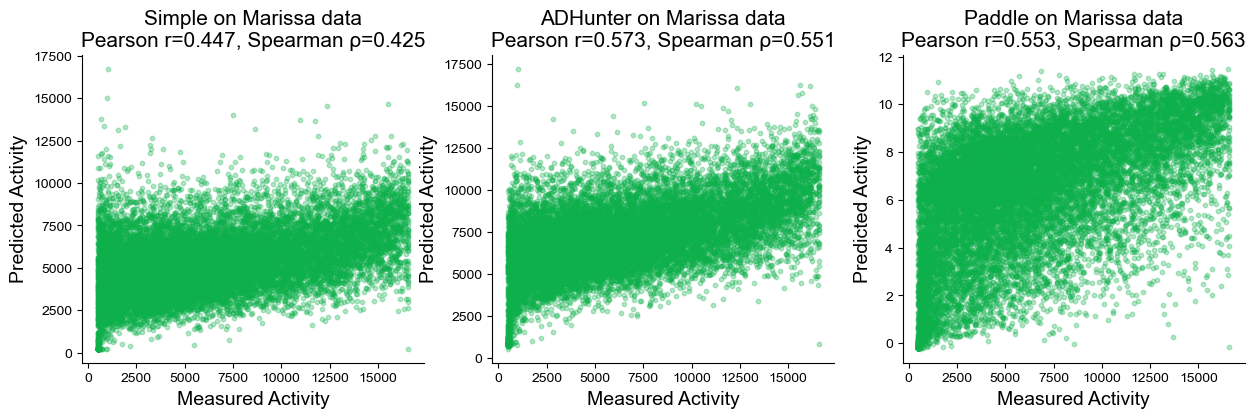

In [134]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


fig, axs = plt.subplots(1,3,figsize=(15,4))

axs[0].scatter(marissa_data["GFP_Activity"], marissa_data["simple_gfp_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(marissa_data["GFP_Activity"], marissa_data["simple_gfp_pred"]).correlation
pearson = pearsonr(marissa_data["GFP_Activity"], marissa_data["simple_gfp_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[0].set_xlabel('Measured Activity', fontsize=14)
axs[0].set_ylabel('Predicted Activity', fontsize=14)
# axs[0].set_ylim(0, 11500)
axs[0].set_title(f'Simple on Marissa data\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)


axs[1].scatter(marissa_data["GFP_Activity"], marissa_data["adhunter_gfp_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(marissa_data.dropna()["GFP_Activity"], marissa_data.dropna()["adhunter_gfp_pred"]).correlation
pearson = pearsonr(marissa_data.dropna()["GFP_Activity"], marissa_data.dropna()["adhunter_gfp_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[1].set_xlabel('Measured Activity', fontsize=14)
axs[1].set_ylabel('Predicted Activity', fontsize=14)
# axs[1].set_ylim(0, 11500)
axs[1].set_title(f'ADHunter on Marissa data\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)

axs[2].scatter(marissa_data["GFP_Activity"], marissa_data["paddle"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(marissa_data.dropna()["GFP_Activity"], marissa_data.dropna()["paddle"]).correlation
pearson = pearsonr(marissa_data.dropna()["GFP_Activity"], marissa_data.dropna()["paddle"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[2].set_xlabel('Measured Activity', fontsize=14)
axs[2].set_ylabel('Predicted Activity', fontsize=14)
# axs[1].set_ylim(0, 11500)
axs[2].set_title(f'Paddle on Marissa data\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)


sns.despine()

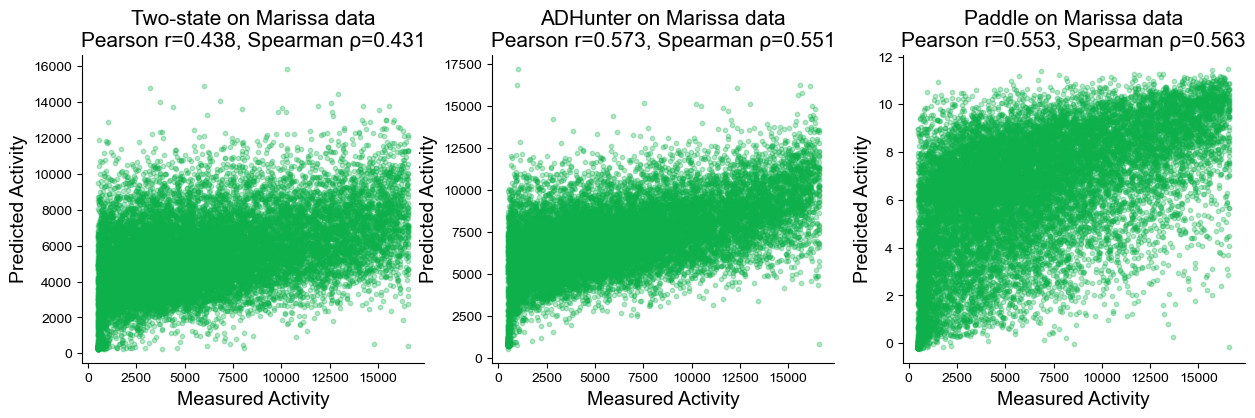

In [138]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


fig, axs = plt.subplots(1,3,figsize=(15,4))

axs[0].scatter(marissa_data["GFP_Activity"], marissa_data["two_state_gfp_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(marissa_data["GFP_Activity"], marissa_data["two_state_gfp_pred"]).correlation
pearson = pearsonr(marissa_data["GFP_Activity"], marissa_data["two_state_gfp_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[0].set_xlabel('Measured Activity', fontsize=14)
axs[0].set_ylabel('Predicted Activity', fontsize=14)
# axs[0].set_ylim(0, 11500)
axs[0].set_title(f'Two-state on Marissa data\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)


axs[1].scatter(marissa_data["GFP_Activity"], marissa_data["adhunter_gfp_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(marissa_data.dropna()["GFP_Activity"], marissa_data.dropna()["adhunter_gfp_pred"]).correlation
pearson = pearsonr(marissa_data.dropna()["GFP_Activity"], marissa_data.dropna()["adhunter_gfp_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[1].set_xlabel('Measured Activity', fontsize=14)
axs[1].set_ylabel('Predicted Activity', fontsize=14)
# axs[1].set_ylim(0, 11500)
axs[1].set_title(f'ADHunter on Marissa data\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)

axs[2].scatter(marissa_data["GFP_Activity"], marissa_data["paddle"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(marissa_data.dropna()["GFP_Activity"], marissa_data.dropna()["paddle"]).correlation
pearson = pearsonr(marissa_data.dropna()["GFP_Activity"], marissa_data.dropna()["paddle"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[2].set_xlabel('Measured Activity', fontsize=14)
axs[2].set_ylabel('Predicted Activity', fontsize=14)
# axs[1].set_ylim(0, 11500)
axs[2].set_title(f'Paddle on Marissa data\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)


sns.despine()

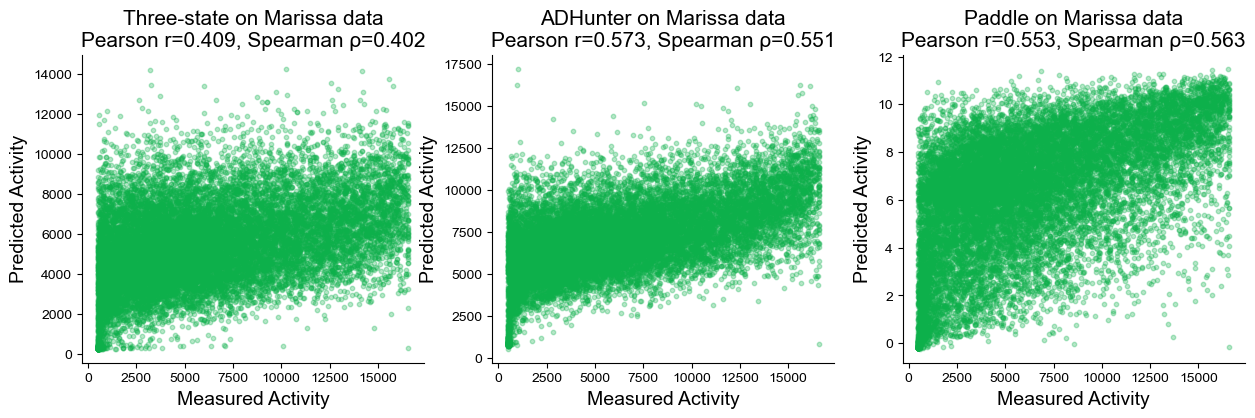

In [137]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


fig, axs = plt.subplots(1,3,figsize=(15,4))

axs[0].scatter(marissa_data["GFP_Activity"], marissa_data["three_state_gfp_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(marissa_data["GFP_Activity"], marissa_data["three_state_gfp_pred"]).correlation
pearson = pearsonr(marissa_data["GFP_Activity"], marissa_data["three_state_gfp_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[0].set_xlabel('Measured Activity', fontsize=14)
axs[0].set_ylabel('Predicted Activity', fontsize=14)
# axs[0].set_ylim(0, 11500)
axs[0].set_title(f'Three-state on Marissa data\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)


axs[1].scatter(marissa_data["GFP_Activity"], marissa_data["adhunter_gfp_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(marissa_data.dropna()["GFP_Activity"], marissa_data.dropna()["adhunter_gfp_pred"]).correlation
pearson = pearsonr(marissa_data.dropna()["GFP_Activity"], marissa_data.dropna()["adhunter_gfp_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[1].set_xlabel('Measured Activity', fontsize=14)
axs[1].set_ylabel('Predicted Activity', fontsize=14)
# axs[1].set_ylim(0, 11500)
axs[1].set_title(f'ADHunter on Marissa data\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)

axs[2].scatter(marissa_data["GFP_Activity"], marissa_data["paddle"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(marissa_data.dropna()["GFP_Activity"], marissa_data.dropna()["paddle"]).correlation
pearson = pearsonr(marissa_data.dropna()["GFP_Activity"], marissa_data.dropna()["paddle"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[2].set_xlabel('Measured Activity', fontsize=14)
axs[2].set_ylabel('Predicted Activity', fontsize=14)
# axs[1].set_ylim(0, 11500)
axs[2].set_title(f'Paddle on Marissa data\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)


sns.despine()

In [ ]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].scatter(marissa_data["GFP_Activity"], marissa_data["simple_gfp_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(marissa_data["GFP_Activity"], marissa_data["simple_gfp_pred"]).correlation
pearson = pearsonr(marissa_data["GFP_Activity"], marissa_data["simple_gfp_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[0].set_xlabel('Measured Activity', fontsize=14)
axs[0].set_ylabel('Predicted Activity', fontsize=14)
# axs[0].set_ylim(0, 11500)
axs[0].set_title(f'Simple on Marissa data\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)


axs[1].scatter(marissa_data["GFP_Activity"], marissa_data["adhunter_gfp_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(marissa_data.dropna()["GFP_Activity"], marissa_data.dropna()["adhunter_gfp_pred"]).correlation
pearson = pearsonr(marissa_data.dropna()["GFP_Activity"], marissa_data.dropna()["adhunter_gfp_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[1].set_xlabel('Measured Activity', fontsize=14)
axs[1].set_ylabel('Predicted Activity', fontsize=14)
# axs[1].set_ylim(0, 11500)
axs[1].set_title(f'ADHunter on Marissa data\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)


sns.despine()

In [ ]:
plt.hist(mari)

,aa_seq,GFP_Activity,GFP_StdDev,NumReps,Ctrl,NegCtrl,simple_gfp_pred,adhunter_gfp_pred,53mer,paddle,40mer,adpred_preds,adpred_preds_mean,tada_preds
0,AAAAAIACELRTDNYFEYPDLSILDALDNDSDETMSLIDE,2998.900453,NaN,1,0,0,5274.527344,8719.949219,SHLATAGSTSSASAAAAAIACELRTDNYFEYPDLSILDALDNDSDE...,4.820709,AAAAAIACELRTDNYFEYPDLSILDALDNDSDETMSLIDE,"[0.0010650251060724258, 0.0039056800305843353,...",0.592839,0.666
1,AAAAASDHSDVNDIIELGGLSNRLYDFYSDLEDIENDIAV,3296.634571,NaN,1,0,0,4347.714844,4954.978027,SHLATAGSTSSASAAAAASDHSDVNDIIELGGLSNRLYDFYSDLED...,8.360944,AAAAASDHSDVNDIIELGGLSNRLYDFYSDLEDIENDIAV,"[0.0015486873453482985, 0.0019946300890296698,...",0.684129,0.633
2,AAADGASFSDDTDEDLYKYDPWDLPGLSVIKTDDPEWFFF,7699.309003,807.776558,4,0,0,5771.591797,9739.866211,SHLATAGSTSSASAAADGASFSDDTDEDLYKYDPWDLPGLSVIKTD...,7.576313,AAADGASFSDDTDEDLYKYDPWDLPGLSVIKTDDPEWFFF,"[0.0018055882537737489, 0.0038003327790647745,...",0.705396,0.663
3,AAADGASFSDDTDEDLYKYDPWELPSKASFGEQEWYFFSP,5480.599003,1011.252956,4,0,0,6443.749023,7588.547363,SHLATAGSTSSASAAADGASFSDDTDEDLYKYDPWELPSKASFGEQ...,3.459946,AAADGASFSDDTDEDLYKYDPWELPSKASFGEQEWYFFSP,"[0.0018055882537737489, 0.0043524522334337234,...",0.568411,0.652
4,AAADGPDCDTREFCELRDSLLWNESCFLLDDDKRFDVSEN,6164.547720,NaN,1,0,0,2962.675537,7349.553223,SHLATAGSTSSASAAADGPDCDTREFCELRDSLLWNESCFLLDDDK...,5.097357,AAADGPDCDTREFCELRDSLLWNESCFLLDDDKRFDVSEN,"[0.0017737216548994184, 0.0053592887707054615,...",0.642051,0.657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16688,YYSDDIMLDLGVDLSNFQFDFRYFGLDSPLSPPWNEDDDS,13805.477165,1177.165879,3,0,0,5648.692871,11085.123047,SHLATAGSTSSASYYSDDIMLDLGVDLSNFQFDFRYFGLDSPLSPP...,8.574873,YYSDDIMLDLGVDLSNFQFDFRYFGLDSPLSPPWNEDDDS,"[0.30664879083633423, 0.42302441596984863, 0.8...",0.796153,0.703
16689,YYSEQSCYLDLDLDLDITFLDFSQFLEQLLQSKNDPLVSE,13686.365240,NaN,2,0,0,7115.131348,9476.196289,SHLATAGSTSSASYYSEQSCYLDLDLDLDITFLDFSQFLEQLLQSK...,9.240496,YYSEQSCYLDLDLDLDITFLDFSQFLEQLLQSKNDPLVSE,"[0.33912914991378784, 0.4771657884120941, 0.87...",0.766623,0.675
16690,YYSEQSCYLNFPPLDCVDLVATLSEKFKSFSQLLLDFPIS,501.915275,NaN,1,0,0,4335.608887,4756.789062,SHLATAGSTSSASYYSEQSCYLNFPPLDCVDLVATLSEKFKSFSQL...,0.851647,YYSEQSCYLNFPPLDCVDLVATLSEKFKSFSQLLLDFPIS,"[0.059167344123125076, 0.14642341434955597, 0....",0.655498,0.503
16691,YYSEQSCYLNFPPLDMFPALPSDLSGWVESMLSELNNPAS,7394.455744,NaN,2,0,0,6466.271484,9208.117188,SHLATAGSTSSASYYSEQSCYLNFPPLDMFPALPSDLSGWVESMLS...,5.940909,YYSEQSCYLNFPPLDMFPALPSDLSGWVESMLSELNNPAS,"[0.07994267344474792, 0.22402198612689972, 0.7...",0.704097,0.659


(array([2970.000, 2632.000, 2439.000, 2051.000, 1652.000, 1278.000,
        1077.000, 1016.000, 832.000, 746.000]),
 array([492.000, 2100.900, 3709.800, 5318.700, 6927.600, 8536.500,
        10145.400, 11754.300, 13363.200, 14972.100, 16581.000]),
 <BarContainer object of 10 artists>)

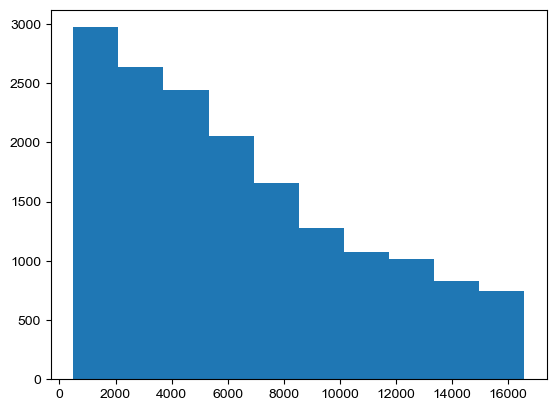

In [127]:
plt.hist(marissa_data['GFP_Activity'])

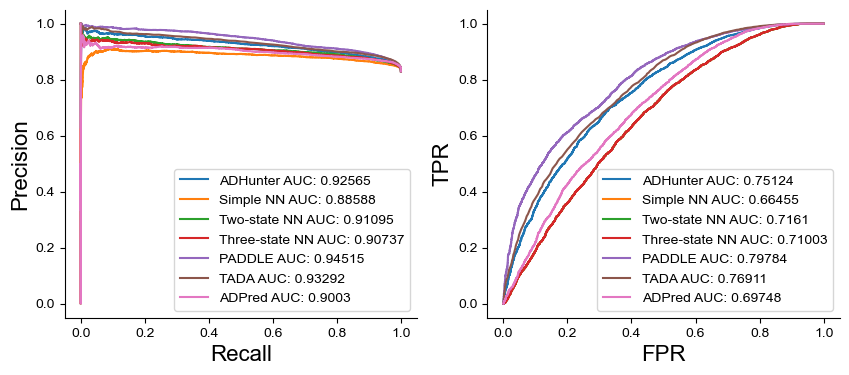

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

experimental_measures = marissa_data['GFP_Activity']
experimental_labels = [i > 2000 for i in experimental_measures]

simple_measures = marissa_data['simple_gfp_pred']
precision_b, recall_b, thresholds_b = precision_recall_curve(experimental_labels, simple_measures)
fpr_b, tpr_b, thresholds_b = roc_curve(experimental_labels, simple_measures)

two_state_measures = marissa_data['two_state_gfp_pred']
precision_two, recall_two, thresholds_two = precision_recall_curve(experimental_labels, two_state_measures)
fpr_two, tpr_two, thresholds_two = roc_curve(experimental_labels, two_state_measures)

three_state_measures = marissa_data['three_state_gfp_pred']
precision_three, recall_three, thresholds_three = precision_recall_curve(experimental_labels, three_state_measures)
fpr_three, tpr_three, thresholds_three = roc_curve(experimental_labels, three_state_measures)

paddle_measures = marissa_data['paddle']
precision_p, recall_p, thresholds_p = precision_recall_curve(experimental_labels, paddle_measures)
fpr_p, tpr_p, thresholds_b = roc_curve(experimental_labels, paddle_measures)

adhunter_measures =  marissa_data['adhunter_gfp_pred']
precision_a, recall_a, thresholds_a = precision_recall_curve(experimental_labels, adhunter_measures)
fpr_a, tpr_a, thresholds_a = roc_curve(experimental_labels, adhunter_measures)

tada_measures = marissa_data['tada_preds']

precision_t, recall_t, thresholds_t = precision_recall_curve(experimental_labels, tada_measures)
fpr_t, tpr_t, thresholds_t = roc_curve(experimental_labels, tada_measures)

adpred_measures = marissa_data['adpred_preds_max']
precision_ad, recall_ad, thresholds_ad = precision_recall_curve(experimental_labels, adpred_measures)
fpr_ad, tpr_ad, thresholds_ad = roc_curve(experimental_labels, adpred_measures)


simple_auc_pr = auc(recall_b, precision_b)
two_auc_pr = auc(recall_two, precision_two)
three_auc_pr = auc(recall_three, precision_three)
adhunter_auc_pr = auc(recall_a, precision_a)
paddle_auc_pr = auc(recall_p, precision_p)
tada_auc_pr = auc(recall_t, precision_t)
adpred_auc_pr = auc(recall_ad, precision_ad)

simple_auc_roc = auc(fpr_b, tpr_b)
two_auc_roc = auc(fpr_two, tpr_two)
three_auc_roc = auc(fpr_three, tpr_three)
adhunter_auc_roc = auc(fpr_a, tpr_a)
paddle_auc_roc = auc(fpr_p, tpr_p)
tada_auc_roc = auc(fpr_t, tpr_t)
adpred_auc_roc = auc(fpr_ad, tpr_ad)

axs[0].plot(recall_a, precision_a, label=f"ADHunter AUC: {adhunter_auc_pr:.5}")
axs[0].plot(recall_b, precision_b, label=f"Simple NN AUC: {simple_auc_pr:.5}")
axs[0].plot(recall_two, precision_two, label=f"Two-state NN AUC: {two_auc_pr:.5}")
axs[0].plot(recall_three, precision_three, label=f"Three-state NN AUC: {three_auc_pr:.5}")
axs[0].plot(recall_p, precision_p, label=f"PADDLE AUC: {paddle_auc_pr:.5}")
axs[0].plot(recall_t, precision_t, label=f"TADA AUC: {tada_auc_pr:.5}")
axs[0].plot(recall_ad, precision_ad, label=f"ADPred AUC: {adpred_auc_pr:.5}")

axs[0].legend(fontsize="10")
axs[0].set_xlabel("Recall", fontsize=16)
axs[0].set_ylabel("Precision", fontsize=16)

axs[1].plot(fpr_a,tpr_a,  label=f"ADHunter AUC: {adhunter_auc_roc:.5}")
axs[1].plot(fpr_b, tpr_b, label=f"Simple NN AUC: {simple_auc_roc:.5}")
axs[1].plot(fpr_b, tpr_b, label=f"Two-state NN AUC: {two_auc_roc:.5}")
axs[1].plot(fpr_b, tpr_b, label=f"Three-state NN AUC: {three_auc_roc:.5}")
axs[1].plot(fpr_p, tpr_p, label=f"PADDLE AUC: {paddle_auc_roc:.5}")
axs[1].plot(fpr_t, tpr_t, label=f"TADA AUC: {tada_auc_roc:.5}")
axs[1].plot(fpr_ad, tpr_ad, label=f"ADPred AUC: {adpred_auc_roc:.5}")

axs[1].legend(fontsize="10")
axs[1].set_xlabel("FPR", fontsize=16)
axs[1].set_ylabel("TPR", fontsize=16)

# fig.suptitle("Centered and Smoothed Data")
sns.despine()
# plt.savefig(f"figures/simple_AUC_plots.pdf", format='pdf', bbox_inches='tight')

# PADI data

In [217]:
PADI_data = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/PADI_ScaleScore_data_wrangled.csv", index_col=0)
PADI_data

,aa_seq,abundance,activity
2,LRNKIEGNTSRDVEVAISEVNICSYDPWNLRFQSKYKSRD,1.765059,-0.764495
3,RDVEVAISEVNICSYDPWNLRFQSKYKSRDAMWYFFSRRE,-0.761484,-0.913925
4,NICSYDPWNLRFQSKYKSRDAMWYFFSRRENNKGNRQSRT,-0.316578,-0.637390
5,RFQSKYKSRDAMWYFFSRRENNKGNRQSRTTVSGKWKLTG,-0.182440,-0.189105
6,AMWYFFSRRENNKGNRQSRTTVSGKWKLTGESVEVKDQWG,-0.201822,0.315959
...,...,...,...
69521,SDFVVKAEDVEASMAIFWTPGTRVKMAMETEDSSRITWFQ,0.237077,-0.031522
69522,EASMAIFWTPGTRVKMAMETEDSSRITWFQGIVFYTYQET,-0.968627,-0.712330
69523,GTRVKMAMETEDSSRITWFQGIVFYTYQETGPWRGSPWNS,0.416401,-0.980707
69524,EDSSRITWFQGIVFYTYQETGPWRGSPWNSFRYKIPFTIP,1.107537,0.496633


In [218]:
PADI_data["simple_gfp_pred"] = [run_biophysical_model(simple_model, tile)[0][0] for tile in PADI_data["aa_seq"]]
PADI_data["adhunter_gfp_pred"] = [run_adhunter(gfp_model, tile, sc_gfp) for tile in PADI_data["aa_seq"]]

In [224]:
PADI_data["two_state_gfp_pred"] = [run_biophysical_model(two_state_biophysical_model, tile)[0][1] for tile in PADI_data["aa_seq"]]
PADI_data["three_state_gfp_pred"] = [run_biophysical_model(three_state_biophysical_model, tile)[0][1] for tile in PADI_data["aa_seq"]]

In [219]:
paddle_padi = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/PADI_PADDLE_ADpred_53_preds.csv", index_col=0, converters={'adpred_preds' : pd.eval})

paddle_padi['paddle_preds'] = [float(ls.replace("]","").replace("[","")) for ls in paddle_padi['paddle_preds']]
paddle_padi['adpred_preds_max'] = [max(ls) for ls in paddle_padi['adpred_preds']]
paddle_padi = paddle_padi.rename({'sequence' : '53mer'}, axis = 1)
paddle_padi['aa_seq'] = paddle_padi["53mer"].str[-40:]

In [220]:
PADI_data = PADI_data.merge(paddle_padi, on='aa_seq')

In [221]:
tada_padi = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/PADI_TADA_Predictions.csv", index_col=0)
tada_padi = tada_padi.rename({'sequences' : 'aa_seq', 'predictions' : 'tada_preds'}, axis=1)

In [222]:
PADI_data = PADI_data.merge(tada_padi, on='aa_seq')

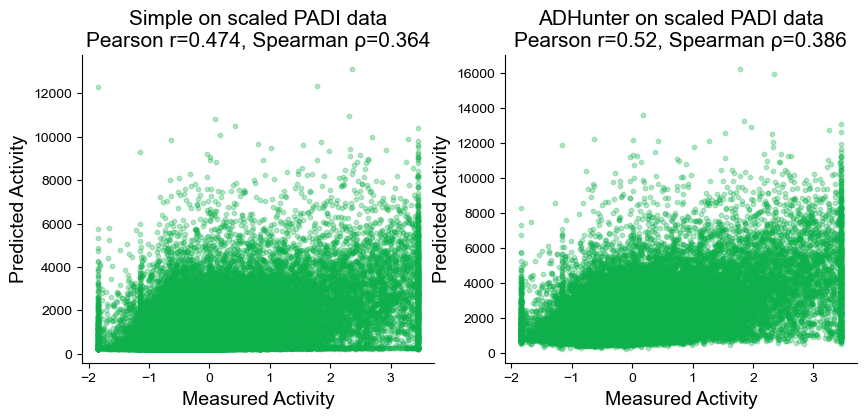

In [223]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].scatter(PADI_data["activity"], PADI_data["simple_gfp_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(PADI_data["activity"], PADI_data["simple_gfp_pred"]).correlation
pearson = pearsonr(PADI_data["activity"], PADI_data["simple_gfp_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[0].set_xlabel('Measured Activity', fontsize=14)
axs[0].set_ylabel('Predicted Activity', fontsize=14)
# axs[0].set_ylim(0, 11500)
axs[0].set_title(f'Simple on scaled PADI data\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)


axs[1].scatter(PADI_data["activity"], PADI_data["adhunter_gfp_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(PADI_data.dropna()["activity"], PADI_data.dropna()["adhunter_gfp_pred"]).correlation
pearson = pearsonr(PADI_data.dropna()["activity"], PADI_data.dropna()["adhunter_gfp_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[1].set_xlabel('Measured Activity', fontsize=14)
axs[1].set_ylabel('Predicted Activity', fontsize=14)
# axs[1].set_ylim(0, 11500)
axs[1].set_title(f'ADHunter on scaled PADI data\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)


sns.despine()

In [ ]:
PADI_data_ADscore = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/PADI_ADScore_data_wrangled.csv", index_col=0)
PADI_data_ADscore

,aa_seq,abundance,activity
2,LRNKIEGNTSRDVEVAISEVNICSYDPWNLRFQSKYKSRD,119.407486,2.139619
3,RDVEVAISEVNICSYDPWNLRFQSKYKSRDAMWYFFSRRE,57.726857,2.009344
4,NICSYDPWNLRFQSKYKSRDAMWYFFSRRENNKGNRQSRT,68.588378,2.250430
5,RFQSKYKSRDAMWYFFSRRENNKGNRQSRTTVSGKWKLTG,71.863085,2.641251
6,AMWYFFSRRENNKGNRQSRTTVSGKWKLTGESVEVKDQWG,71.389912,3.081572
...,...,...,...
69521,SDFVVKAEDVEASMAIFWTPGTRVKMAMETEDSSRITWFQ,82.104793,2.778634
69522,EASMAIFWTPGTRVKMAMETEDSSRITWFQGIVFYTYQET,52.669874,2.185097
69523,GTRVKMAMETEDSSRITWFQGIVFYTYQETGPWRGSPWNS,86.482637,1.951123
69524,EDSSRITWFQGIVFYTYQETGPWRGSPWNSFRYKIPFTIP,103.355376,3.239086


In [ ]:
PADI_data["simple_gfp_pred"] = [run_biophysical_model(simple_model, tile)[0][0] for tile in PADI_data_ADscore["aa_seq"]]
PADI_data["adhunter_gfp_pred"] = [run_adhunter(gfp_model, tile, sc_gfp) for tile in PADI_data_ADscore["aa_seq"]]

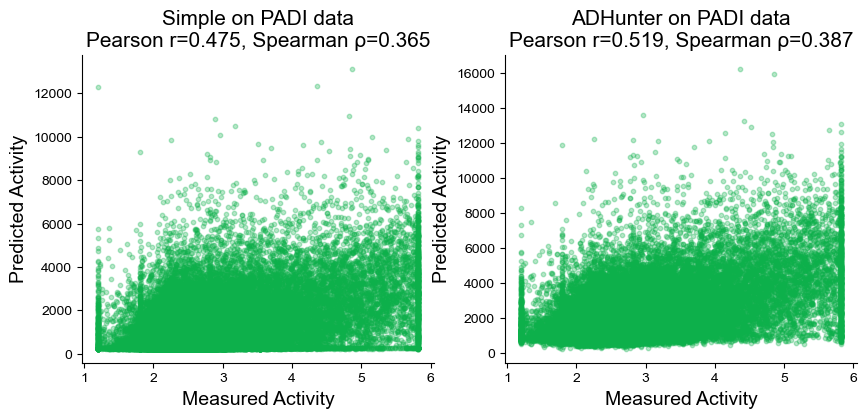

In [187]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].scatter(PADI_data["activity"], PADI_data["simple_gfp_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(PADI_data["activity"], PADI_data["simple_gfp_pred"]).correlation
pearson = pearsonr(PADI_data["activity"], PADI_data["simple_gfp_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[0].set_xlabel('Measured Activity', fontsize=14)
axs[0].set_ylabel('Predicted Activity', fontsize=14)
# axs[0].set_ylim(0, 11500)
axs[0].set_title(f'Simple on PADI data\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)


axs[1].scatter(PADI_data["activity"], PADI_data["adhunter_gfp_pred"], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(PADI_data.dropna()["activity"], PADI_data.dropna()["adhunter_gfp_pred"]).correlation
pearson = pearsonr(PADI_data.dropna()["activity"], PADI_data.dropna()["adhunter_gfp_pred"]).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1] 
axs[1].set_xlabel('Measured Activity', fontsize=14)
axs[1].set_ylabel('Predicted Activity', fontsize=14)
# axs[1].set_ylim(0, 11500)
axs[1].set_title(f'ADHunter on PADI data\nPearson r={pearson:.3}, Spearman \u03C1={spearman:.3}', fontsize=15)


sns.despine()

In [198]:
PADI_data

,aa_seq,abundance,activity,simple_gfp_pred,adhunter_gfp_pred,two_state_gfp_pred,three_state_gfp_pred,53mer,paddle_centers,paddle_preds,adpred_preds,adpred_preds_max
0,LRNKIEGNTSRDVEVAISEVNICSYDPWNLRFQSKYKSRD,119.407486,2.139619,848.382019,3186.418701,263.412323,571.905273,SHLATAGSTSSASLRNKIEGNTSRDVEVAISEVNICSYDPWNLRFQ...,[27.0],0.629598,"[0.00016927446995396167, 0.0001939146895892918...",0.703003
1,RDVEVAISEVNICSYDPWNLRFQSKYKSRDAMWYFFSRRE,57.726857,2.009344,2195.395508,3521.298340,1331.377930,2522.190186,SHLATAGSTSSASRDVEVAISEVNICSYDPWNLRFQSKYKSRDAMW...,[27.0],0.363775,"[0.00014313111023511738, 0.0001745809422573074...",0.807308
2,NICSYDPWNLRFQSKYKSRDAMWYFFSRRENNKGNRQSRT,68.588378,2.250430,1117.235107,2095.692627,419.925751,927.800171,SHLATAGSTSSASNICSYDPWNLRFQSKYKSRDAMWYFFSRRENNK...,[27.0],0.819697,"[0.00026317356969229877, 0.0004189985047560185...",0.735520
3,RFQSKYKSRDAMWYFFSRRENNKGNRQSRTTVSGKWKLTG,71.863085,2.641251,425.875702,2200.720947,273.842224,262.181458,SHLATAGSTSSASRFQSKYKSRDAMWYFFSRRENNKGNRQSRTTVS...,[27.0],0.130473,"[0.0003020395524799824, 0.00024237744219135493...",0.046850
4,AMWYFFSRRENNKGNRQSRTTVSGKWKLTGESVEVKDQWG,71.389912,3.081572,244.848297,1672.776489,259.572205,301.429779,SHLATAGSTSSASAMWYFFSRRENNKGNRQSRTTVSGKWKLTGESV...,[27.0],0.355597,"[0.0002999842108692974, 0.0018222089856863022,...",0.233772
...,...,...,...,...,...,...,...,...,...,...,...,...
57269,SDFVVKAEDVEASMAIFWTPGTRVKMAMETEDSSRITWFQ,82.104793,2.778634,1084.241699,2772.000977,2349.802490,1922.530884,SHLATAGSTSSASSDFVVKAEDVEASMAIFWTPGTRVKMAMETEDS...,[27.0],1.089659,"[0.00022552577138412744, 0.0006685156258754432...",0.243416
57270,EASMAIFWTPGTRVKMAMETEDSSRITWFQGIVFYTYQET,52.669874,2.185097,1786.696533,2098.410645,3278.293701,2511.299561,SHLATAGSTSSASEASMAIFWTPGTRVKMAMETEDSSRITWFQGIV...,[27.0],0.146655,"[0.00018926608026959002, 0.0001905658864416182...",0.128140
57271,GTRVKMAMETEDSSRITWFQGIVFYTYQETGPWRGSPWNS,86.482637,1.951123,2789.520264,3387.902588,1588.957153,2780.493896,SHLATAGSTSSASGTRVKMAMETEDSSRITWFQGIVFYTYQETGPW...,[27.0],0.401462,"[0.00015455749235115945, 0.0001073513994924724...",0.115672
57272,EDSSRITWFQGIVFYTYQETGPWRGSPWNSFRYKIPFTIP,103.355376,3.239086,2571.514404,2928.539551,2208.143799,1697.262695,SHLATAGSTSSASEDSSRITWFQGIVFYTYQETGPWRGSPWNSFRY...,[27.0],0.076195,"[0.0002558695268817246, 0.0002454885980114341,...",0.124681


(array([1075.000, 6776.000, 24249.000, 15364.000, 6728.000, 3383.000,
        1875.000, 1244.000, 1142.000, 1482.000]),
 array([1.200, 1.662, 2.124, 2.586, 3.048, 3.510, 3.972, 4.434, 4.896,
        5.358, 5.820]),
 <BarContainer object of 10 artists>)

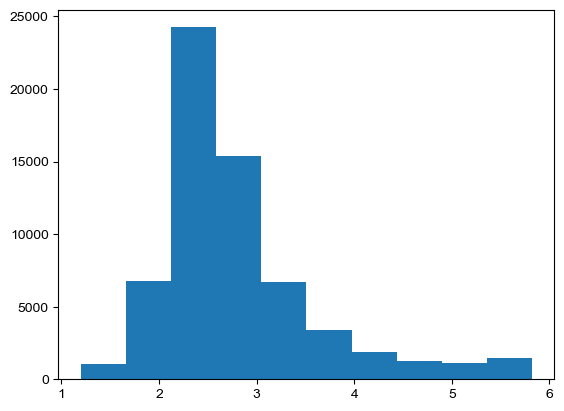

In [211]:
plt.hist(PADI_data['activity'])

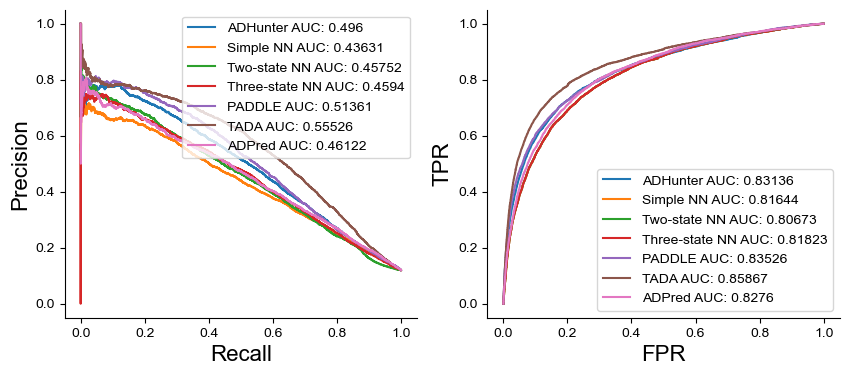

In [226]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

experimental_measures = PADI_data['activity']
experimental_labels = [i > 1 for i in experimental_measures]

simple_measures = PADI_data['simple_gfp_pred']
precision_b, recall_b, thresholds_b = precision_recall_curve(experimental_labels, simple_measures)
fpr_b, tpr_b, thresholds_b = roc_curve(experimental_labels, simple_measures)

two_state_measures = PADI_data['two_state_gfp_pred']
precision_two, recall_two, thresholds_two = precision_recall_curve(experimental_labels, two_state_measures)
fpr_two, tpr_two, thresholds_two = roc_curve(experimental_labels, two_state_measures)

three_state_measures = PADI_data['three_state_gfp_pred']
precision_three, recall_three, thresholds_three = precision_recall_curve(experimental_labels, three_state_measures)
fpr_three, tpr_three, thresholds_three = roc_curve(experimental_labels, three_state_measures)

paddle_measures = PADI_data['paddle_preds']
precision_p, recall_p, thresholds_p = precision_recall_curve(experimental_labels, paddle_measures)
fpr_p, tpr_p, thresholds_b = roc_curve(experimental_labels, paddle_measures)

adhunter_measures =  PADI_data['adhunter_gfp_pred']
precision_a, recall_a, thresholds_a = precision_recall_curve(experimental_labels, adhunter_measures)
fpr_a, tpr_a, thresholds_a = roc_curve(experimental_labels, adhunter_measures)

tada_measures = PADI_data['tada_preds']

precision_t, recall_t, thresholds_t = precision_recall_curve(experimental_labels, tada_measures)
fpr_t, tpr_t, thresholds_t = roc_curve(experimental_labels, tada_measures)

adpred_measures = PADI_data['adpred_preds_max']
precision_ad, recall_ad, thresholds_ad = precision_recall_curve(experimental_labels, adpred_measures)
fpr_ad, tpr_ad, thresholds_ad = roc_curve(experimental_labels, adpred_measures)


simple_auc_pr = auc(recall_b, precision_b)
two_auc_pr = auc(recall_two, precision_two)
three_auc_pr = auc(recall_three, precision_three)
adhunter_auc_pr = auc(recall_a, precision_a)
paddle_auc_pr = auc(recall_p, precision_p)
tada_auc_pr = auc(recall_t, precision_t)
adpred_auc_pr = auc(recall_ad, precision_ad)

simple_auc_roc = auc(fpr_b, tpr_b)
two_auc_roc = auc(fpr_two, tpr_two)
three_auc_roc = auc(fpr_three, tpr_three)
adhunter_auc_roc = auc(fpr_a, tpr_a)
paddle_auc_roc = auc(fpr_p, tpr_p)
tada_auc_roc = auc(fpr_t, tpr_t)
adpred_auc_roc = auc(fpr_ad, tpr_ad)

axs[0].plot(recall_a, precision_a, label=f"ADHunter AUC: {adhunter_auc_pr:.5}")
axs[0].plot(recall_b, precision_b, label=f"Simple NN AUC: {simple_auc_pr:.5}")
axs[0].plot(recall_two, precision_two, label=f"Two-state NN AUC: {two_auc_pr:.5}")
axs[0].plot(recall_three, precision_three, label=f"Three-state NN AUC: {three_auc_pr:.5}")
axs[0].plot(recall_p, precision_p, label=f"PADDLE AUC: {paddle_auc_pr:.5}")
axs[0].plot(recall_t, precision_t, label=f"TADA AUC: {tada_auc_pr:.5}")
axs[0].plot(recall_ad, precision_ad, label=f"ADPred AUC: {adpred_auc_pr:.5}")

axs[0].legend(fontsize="10")
axs[0].set_xlabel("Recall", fontsize=16)
axs[0].set_ylabel("Precision", fontsize=16)

axs[1].plot(fpr_a,tpr_a,  label=f"ADHunter AUC: {adhunter_auc_roc:.5}")
axs[1].plot(fpr_b, tpr_b, label=f"Simple NN AUC: {simple_auc_roc:.5}")
axs[1].plot(fpr_b, tpr_b, label=f"Two-state NN AUC: {two_auc_roc:.5}")
axs[1].plot(fpr_b, tpr_b, label=f"Three-state NN AUC: {three_auc_roc:.5}")
axs[1].plot(fpr_p, tpr_p, label=f"PADDLE AUC: {paddle_auc_roc:.5}")
axs[1].plot(fpr_t, tpr_t, label=f"TADA AUC: {tada_auc_roc:.5}")
axs[1].plot(fpr_ad, tpr_ad, label=f"ADPred AUC: {adpred_auc_roc:.5}")

axs[1].legend(fontsize="10")
axs[1].set_xlabel("FPR", fontsize=16)
axs[1].set_ylabel("TPR", fontsize=16)

# fig.suptitle("Centered and Smoothed Data")
sns.despine()
# plt.savefig(f"figures/simple_AUC_plots.pdf", format='pdf', bbox_inches='tight')